In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    accuracy_score, classification_report, confusion_matrix,
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# UMAP import
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("Warning: umap-learn not installed. UMAP plots will be skipped.")

# Lifelines for C-index
try:
    from lifelines.utils import concordance_index
    HAS_LIFELINES = True
except ImportError:
    HAS_LIFELINES = False
    print("Warning: lifelines not installed. C-index will not be computed.")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f">>> Running on: {DEVICE}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

>>> Running on: cuda


In [18]:
BEST_PARAMS = {
    'n_features': 2000,
    'latent_dim': 64,
    'hidden_dim': 128,
    'fusion_hidden_dim': 64,
    'lr_pre': 0.0002146758585108322,
    'lr_fine': 0.00011360532119650048,
    'dropout_rate': 0.11015537480141437,
    'dropout_encoder': 0.22590162867072883,
    'weight_decay': 1.9336124732004638e-05,
    'noise_level': 0.2184491078143125,
    'noise_type': 'uniform',
    'focal_gamma': 4.050282882242696,
    'focal_alpha_scale': 1.8214490747770962,
    'use_class_weights': False,
    'max_rel_gap_pre': 0.33104531983955027,
    'max_rel_gap_fine': 0.29846272422979525,
    'overfit_patience': 10,
    'no_improve_patience': 46,
    'ntxent_temperature': 0.2989172299699971,
    'ntxent_weight': 7.766899511244319
}

SUBTYPES_OF_INTEREST = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma',
    'Fibromyxosarcoma'
]

print("Best Hyperparameters loaded!")
print(f"  Latent Dim: {BEST_PARAMS['latent_dim']}")
print(f"  Learning Rate (Pretrain): {BEST_PARAMS['lr_pre']:.6f}")
print(f"  Learning Rate (Fine-tune): {BEST_PARAMS['lr_fine']:.6f}")

Best Hyperparameters loaded!
  Latent Dim: 64
  Learning Rate (Pretrain): 0.000215
  Learning Rate (Fine-tune): 0.000114


In [19]:
def load_raw_aligned_data():
    print(f"\n>>> LOADING RAW ALIGNED DATA")

    pheno_path = "../Data/phenotype_clean.csv"
    if not os.path.exists(pheno_path):
        raise FileNotFoundError(f"{pheno_path} not found.")

    pheno = pd.read_csv(pheno_path, index_col=0)

    col_name = 'primary_diagnosis.diagnoses'
    if col_name not in pheno.columns:
        print(f"Warning: '{col_name}' not found. Available: {pheno.columns.tolist()}")
        return None

    mask = pheno[col_name].isin(SUBTYPES_OF_INTEREST)
    pheno = pheno[mask]
    print(f"  Phenotype Samples (filtered): {pheno.shape[0]}")

    def load_omic(path, name):
        if not os.path.exists(path):
            print(f"Warning: {path} not found. Skipping {name}.")
            return None
        df = pd.read_csv(path, index_col=0)
        df = df.T  # samples x features
        return df

    rna = load_omic("../Data/expression_log.csv", "RNA (Expression)")
    meth = load_omic("../Data/methylation_mvalues.csv", "Methylation")
    cnv = load_omic("../Data/cnv_log.csv", "CNV")

    if rna is None or meth is None or cnv is None:
        raise ValueError("One or more omics files missing.")

    common_samples = pheno.index.intersection(rna.index).intersection(meth.index).intersection(cnv.index)
    print(f"  Common Samples: {len(common_samples)}")

    if len(common_samples) == 0:
        raise ValueError("No common samples found!")

    pheno = pheno.loc[common_samples]
    rna = rna.loc[common_samples]
    meth = meth.loc[common_samples]
    cnv = cnv.loc[common_samples]

    le = LabelEncoder()
    Y = le.fit_transform(pheno[col_name])
    print(f"  Classes: {le.classes_}")

    class_counts = np.bincount(Y)
    class_weights = len(Y) / (len(class_counts) * class_counts)
    class_weights = class_weights / class_weights.sum()
    print(f"  Class Counts: {class_counts}")
    print(f"  Class Weights (normalized): {class_weights}")

    # Survival Data
    T, E = None, None
    if 'days_to_death' in pheno.columns and 'vital_status' in pheno.columns:
        events = (pheno['vital_status'].isin(['Dead', 'Deceased'])).astype(int).values
        times = np.zeros(len(pheno))
        if 'days_to_death' in pheno.columns:
            mask_d = events == 1
            d_times = pd.to_numeric(pheno['days_to_death'], errors='coerce').fillna(0).values
            times[mask_d] = d_times[mask_d]
        col_fup = 'days_to_last_follow_up' if 'days_to_last_follow_up' in pheno.columns else 'days_to_last_followup'
        if col_fup in pheno.columns:
            mask_a = events == 0
            f_times = pd.to_numeric(pheno[col_fup], errors='coerce').fillna(0).values
            times[mask_a] = f_times[mask_a]
        T = times
        E = events

    return rna, meth, cnv, Y, T, E, le.classes_, class_weights


In [20]:
class NTXentLoss(nn.Module):
    """NT-Xent Loss for contrastive learning"""
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        z = torch.cat([z_i, z_j], dim=0)
        sim = torch.mm(z, z.t()) / self.temperature
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim.masked_fill_(mask, -9e15)
        target = torch.arange(batch_size, device=z.device)
        target = torch.cat([target + batch_size, target], dim=0)
        loss = F.cross_entropy(sim, target)
        return loss


class PerOmicCMAE(nn.Module):
    """Per-Omic Contrastive Masked Autoencoder"""
    
    def __init__(self, input_dim, latent_dim=64, hidden_dim=256, dropout_encoder=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim), 
            nn.GELU(),
            nn.Dropout(dropout_encoder),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), 
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.projector = nn.Sequential(
            nn.Linear(latent_dim, latent_dim), 
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )

    def forward(self, x, noise_level=0.0, noise_type='gaussian', encode_only=False):
        if self.training and noise_level > 0:
            if noise_type == 'gaussian':
                noise = torch.randn_like(x) * noise_level
                x_corrupted = x + noise
            elif noise_type == 'uniform':
                noise = (torch.rand_like(x) - 0.5) * 2 * noise_level
                x_corrupted = x + noise
            elif noise_type == 'dropout':
                mask = torch.bernoulli(torch.ones_like(x) * (1 - noise_level))
                x_corrupted = x * mask
            else:
                x_corrupted = x
        else:
            x_corrupted = x

        z = self.encoder(x_corrupted)
        
        if encode_only:
            return None, None, z, x_corrupted
        
        rec = self.decoder(z)
        proj = self.projector(z)

        return rec, proj, z, x_corrupted


class GatedAttentionFusion(nn.Module):
    """Gated Attention Fusion for multi-omics"""
    def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
        super().__init__()
        self.gate_rna = nn.Linear(latent_dim, 1)
        self.gate_meth = nn.Linear(latent_dim, 1)
        self.gate_clin = nn.Linear(latent_dim, 1) 
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        self.drop_rate = dropout_rate

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        if apply_dropout and self.training:
            if torch.rand(1).item() < self.drop_rate: z_rna = torch.zeros_like(z_rna)
            if torch.rand(1).item() < self.drop_rate: z_meth = torch.zeros_like(z_meth)
            if torch.rand(1).item() < self.drop_rate: z_clin = torch.zeros_like(z_clin)

        w_rna = torch.sigmoid(self.gate_rna(z_rna))
        w_meth = torch.sigmoid(self.gate_meth(z_meth))
        w_clin = torch.sigmoid(self.gate_clin(z_clin))

        z_fused = torch.cat([w_rna * z_rna, w_meth * z_meth, w_clin * z_clin], dim=1)
        
        return self.classifier(z_fused), torch.cat([w_rna, w_meth, w_clin], dim=1), z_fused


class FocalLoss(nn.Module):
    """Focal Loss for imbalanced classification"""
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                if self.alpha.device != inputs.device:
                    self.alpha = self.alpha.to(inputs.device)
                alpha_t = self.alpha.gather(0, targets)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("Model classes defined!")


Model classes defined!


In [21]:
result = load_raw_aligned_data()
if result is None:
    raise ValueError("Failed to load data!")
    
rna_df, meth_df, cnv_df, Y, T_surv, E_surv, class_names, class_weights = result

print(f"\nData loaded successfully!")
print(f"  Total samples: {len(Y)}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Class names: {list(class_names)}")

#  [markdown]
# ## 6. Training and Evaluation Function

# 
def run_full_evaluation(rna_df, meth_df, cnv_df, Y, T, E, class_names, class_weights, params):
    """
    Run 5-fold cross-validation with the best hyperparameters
    Returns embeddings for all samples for visualization
    """
    
    n_features = params['n_features']
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Per-fold metrics
    fold_metrics = {
        'accuracy': [], 'f1_macro': [], 'f1_micro': [],
        'precision': [], 'recall': [], 'c_index': []
    }
    
    # Store all embeddings and predictions
    all_embeddings = np.zeros((len(Y), params['latent_dim'] * 3))  # fused embeddings
    all_preds = np.zeros(len(Y), dtype=int)
    all_probs = np.zeros((len(Y), len(class_names)))
    
    # Extract hyperparameters
    latent_dim = params['latent_dim']
    hidden_dim = params['hidden_dim']
    fusion_hidden_dim = params['fusion_hidden_dim']
    lr_pre = params['lr_pre']
    lr_fine = params['lr_fine']
    dropout_rate = params['dropout_rate']
    dropout_encoder = params['dropout_encoder']
    noise_level = params['noise_level']
    noise_type = params['noise_type']
    focal_gamma = params['focal_gamma']
    focal_alpha_scale = params['focal_alpha_scale']
    use_class_weights = params['use_class_weights']
    weight_decay = params['weight_decay']
    max_rel_gap_pre = params['max_rel_gap_pre']
    max_rel_gap_fine = params['max_rel_gap_fine']
    overfit_patience = params['overfit_patience']
    no_improve_patience = params['no_improve_patience']
    ntxent_temp = params['ntxent_temperature']
    ntxent_weight = params['ntxent_weight']
    
    MAX_EPOCHS_PRE = 500
    MAX_EPOCHS_FINE = 1000
    min_lr_reductions = 2

    for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
        print(f"\n--- Fold {fold + 1}/5 ---")
        
        # --- A. Data Processing ---
        tr_rna_raw, val_rna_raw = rna_df.iloc[train_idx], rna_df.iloc[val_idx]
        tr_meth_raw, val_meth_raw = meth_df.iloc[train_idx], meth_df.iloc[val_idx]
        tr_cnv_raw, val_cnv_raw = cnv_df.iloc[train_idx], cnv_df.iloc[val_idx]

        def simple_impute_data(train_data, val_data):
            imputer = SimpleImputer(strategy='median')
            tr_imputed = imputer.fit_transform(train_data.values)
            val_imputed = imputer.transform(val_data.values)
            return tr_imputed, val_imputed

        tr_rna_imp, val_rna_imp = simple_impute_data(tr_rna_raw, val_rna_raw)
        tr_meth_imp, val_meth_imp = simple_impute_data(tr_meth_raw, val_meth_raw)
        tr_cnv_imp, val_cnv_imp = simple_impute_data(tr_cnv_raw, val_cnv_raw)

        def get_top_k_indices(data, k):
            vars = np.var(data, axis=0)
            return np.argpartition(vars, -k)[-k:] if data.shape[1] > k else np.arange(data.shape[1])

        r_idx = get_top_k_indices(tr_rna_imp, n_features)
        m_idx = get_top_k_indices(tr_meth_imp, n_features)
        c_idx = get_top_k_indices(tr_cnv_imp, n_features)

        tr_rna_sel = tr_rna_imp[:, r_idx]; val_rna_sel = val_rna_imp[:, r_idx]
        tr_meth_sel = tr_meth_imp[:, m_idx]; val_meth_sel = val_meth_imp[:, m_idx]
        tr_cnv_sel = tr_cnv_imp[:, c_idx]; val_cnv_sel = val_cnv_imp[:, c_idx]

        sc_r = StandardScaler(); sc_m = StandardScaler(); sc_c = StandardScaler()
        tr_rna = sc_r.fit_transform(tr_rna_sel); val_rna = sc_r.transform(val_rna_sel)
        tr_meth = sc_m.fit_transform(tr_meth_sel); val_meth = sc_m.transform(val_meth_sel)
        tr_cnv = sc_c.fit_transform(tr_cnv_sel); val_cnv = sc_c.transform(val_cnv_sel)

        dims = (tr_rna.shape[1], tr_meth.shape[1], tr_cnv.shape[1])

        # Tensors
        t_tr_r = torch.FloatTensor(tr_rna).to(DEVICE)
        t_tr_m = torch.FloatTensor(tr_meth).to(DEVICE)
        t_tr_c = torch.FloatTensor(tr_cnv).to(DEVICE)
        t_tr_y = torch.LongTensor(Y[train_idx]).to(DEVICE)

        t_val_r = torch.FloatTensor(val_rna).to(DEVICE)
        t_val_m = torch.FloatTensor(val_meth).to(DEVICE)
        t_val_c = torch.FloatTensor(val_cnv).to(DEVICE)
        t_val_y = torch.LongTensor(Y[val_idx]).to(DEVICE)

        # --- B. Model Init ---
        cmae_r = PerOmicCMAE(dims[0], latent_dim, hidden_dim, dropout_encoder).to(DEVICE)
        cmae_m = PerOmicCMAE(dims[1], latent_dim, hidden_dim, dropout_encoder).to(DEVICE)
        cmae_c = PerOmicCMAE(dims[2], latent_dim, hidden_dim, dropout_encoder).to(DEVICE)

        opt_pre = optim.AdamW(
            list(cmae_r.parameters()) + list(cmae_m.parameters()) + list(cmae_c.parameters()),
            lr=lr_pre, weight_decay=weight_decay
        )

        # --- C. Pretraining ---
        criterion_ntxent = NTXentLoss(temperature=ntxent_temp).to(DEVICE)
        best_pre_val_loss = float('inf')
        best_cmae_states = None
        overfit_counter_pre = 0
        no_improve_counter_pre = 0
        
        scheduler_pre = ReduceLROnPlateau(opt_pre, mode='min', factor=0.5, 
                                          patience=overfit_patience // 2, min_lr=1e-6)
        lr_reductions_pre = 0
        prev_lr_pre = lr_pre

        for epoch in range(MAX_EPOCHS_PRE):
            cmae_r.train(); cmae_m.train(); cmae_c.train()
            rec_r1, proj_r1, _, _ = cmae_r(t_tr_r, noise_level=noise_level, noise_type=noise_type)
            rec_m1, proj_m1, _, _ = cmae_m(t_tr_m, noise_level=noise_level, noise_type=noise_type)
            rec_c1, proj_c1, _, _ = cmae_c(t_tr_c, noise_level=noise_level, noise_type=noise_type)

            loss_recon_tr = F.mse_loss(rec_r1, t_tr_r) + F.mse_loss(rec_m1, t_tr_m) + F.mse_loss(rec_c1, t_tr_c)
            loss_nt = (criterion_ntxent(proj_r1, proj_m1) + 
                       criterion_ntxent(proj_r1, proj_c1) + 
                       criterion_ntxent(proj_m1, proj_c1)) / 3.0
            train_loss = loss_recon_tr + ntxent_weight * loss_nt

            opt_pre.zero_grad()
            train_loss.backward()
            opt_pre.step()

            cmae_r.eval(); cmae_m.eval(); cmae_c.eval()
            with torch.no_grad():
                rec_r_val, proj_r_val, _, _ = cmae_r(t_val_r, noise_level=0.0)
                rec_m_val, proj_m_val, _, _ = cmae_m(t_val_m, noise_level=0.0)
                rec_c_val, proj_c_val, _, _ = cmae_c(t_val_c, noise_level=0.0)
                
                loss_recon_val = F.mse_loss(rec_r_val, t_val_r) + F.mse_loss(rec_m_val, t_val_m) + F.mse_loss(rec_c_val, t_val_c)
                loss_nt_val = (criterion_ntxent(proj_r_val, proj_m_val) + 
                               criterion_ntxent(proj_r_val, proj_c_val) + 
                               criterion_ntxent(proj_m_val, proj_c_val)) / 3.0
                val_loss = loss_recon_val + ntxent_weight * loss_nt_val

            val_loss_item = val_loss.item()
            train_loss_item = train_loss.item()
            
            scheduler_pre.step(val_loss_item)
            current_lr = opt_pre.param_groups[0]['lr']
            if current_lr < prev_lr_pre:
                lr_reductions_pre += 1
                prev_lr_pre = current_lr
            
            rel_gap = (val_loss_item - train_loss_item) / max(train_loss_item, 0.01)

            if val_loss_item < best_pre_val_loss:
                best_pre_val_loss = val_loss_item
                best_cmae_states = {
                    'cmae_r': cmae_r.state_dict(),
                    'cmae_m': cmae_m.state_dict(),
                    'cmae_c': cmae_c.state_dict()
                }
                no_improve_counter_pre = 0
            else:
                no_improve_counter_pre += 1
            
            if rel_gap > max_rel_gap_pre:
                overfit_counter_pre += 1
            else:
                overfit_counter_pre = 0
            
            if lr_reductions_pre >= min_lr_reductions:
                if overfit_counter_pre >= overfit_patience or no_improve_counter_pre >= no_improve_patience:
                    break

        if best_cmae_states:
            cmae_r.load_state_dict(best_cmae_states['cmae_r'])
            cmae_m.load_state_dict(best_cmae_states['cmae_m'])
            cmae_c.load_state_dict(best_cmae_states['cmae_c'])

        # --- D. Fine-tuning ---
        fusion = GatedAttentionFusion(
            latent_dim, num_classes=len(np.unique(Y)), 
            dropout_rate=dropout_rate, hidden_dim=fusion_hidden_dim
        ).to(DEVICE)

        if use_class_weights:
            alpha = torch.FloatTensor(class_weights * focal_alpha_scale).to(DEVICE)
        else:
            alpha = None
            
        criterion = FocalLoss(gamma=focal_gamma, alpha=alpha)

        opt_fine = optim.AdamW(
            list(cmae_r.encoder.parameters()) + list(cmae_m.encoder.parameters()) + 
            list(cmae_c.encoder.parameters()) + list(fusion.parameters()),
            lr=lr_fine, weight_decay=weight_decay
        )

        scheduler_fine = ReduceLROnPlateau(opt_fine, mode='min', factor=0.5,
                                           patience=overfit_patience // 2, min_lr=1e-7)
        lr_reductions_fine = 0
        prev_lr_fine = lr_fine

        best_fine_val_loss = float('inf')
        best_state = None
        best_encoder_states = None
        overfit_counter_fine = 0
        no_improve_counter_fine = 0

        for epoch in range(MAX_EPOCHS_FINE):
            cmae_r.train(); cmae_m.train(); cmae_c.train()
            fusion.train()
            
            _, _, zr_tr, _ = cmae_r(t_tr_r, noise_level=0.0, encode_only=True)
            _, _, zm_tr, _ = cmae_m(t_tr_m, noise_level=0.0, encode_only=True)
            _, _, zc_tr, _ = cmae_c(t_tr_c, noise_level=0.0, encode_only=True)
            
            logits, weights, _ = fusion(zr_tr, zm_tr, zc_tr, apply_dropout=True)
            train_loss_cls = criterion(logits, t_tr_y)
            opt_fine.zero_grad()
            train_loss_cls.backward()
            opt_fine.step()

            cmae_r.eval(); cmae_m.eval(); cmae_c.eval()
            fusion.eval()
            with torch.no_grad():
                _, _, zr_val, _ = cmae_r(t_val_r, noise_level=0.0, encode_only=True)
                _, _, zm_val, _ = cmae_m(t_val_m, noise_level=0.0, encode_only=True)
                _, _, zc_val, _ = cmae_c(t_val_c, noise_level=0.0, encode_only=True)
                v_logits, _, v_fused = fusion(zr_val, zm_val, zc_val, apply_dropout=False)
                val_loss_cls = criterion(v_logits, t_val_y)

            train_loss_item = val_loss_cls.item()
            val_loss_item = val_loss_cls.item()
            
            scheduler_fine.step(val_loss_item)
            current_lr = opt_fine.param_groups[0]['lr']
            if current_lr < prev_lr_fine:
                lr_reductions_fine += 1
                prev_lr_fine = current_lr
            
            rel_gap = (val_loss_item - train_loss_item) / max(train_loss_item, 0.01)

            if val_loss_item < best_fine_val_loss:
                best_fine_val_loss = val_loss_item
                best_state = fusion.state_dict()
                best_encoder_states = {
                    'cmae_r': cmae_r.state_dict(),
                    'cmae_m': cmae_m.state_dict(),
                    'cmae_c': cmae_c.state_dict()
                }
                no_improve_counter_fine = 0
            else:
                no_improve_counter_fine += 1
            
            if rel_gap > max_rel_gap_fine:
                overfit_counter_fine += 1
            else:
                overfit_counter_fine = 0
            
            if lr_reductions_fine >= min_lr_reductions:
                if overfit_counter_fine >= overfit_patience or no_improve_counter_fine >= no_improve_patience:
                    break

        if best_state:
            fusion.load_state_dict(best_state)
        if best_encoder_states:
            cmae_r.load_state_dict(best_encoder_states['cmae_r'])
            cmae_m.load_state_dict(best_encoder_states['cmae_m'])
            cmae_c.load_state_dict(best_encoder_states['cmae_c'])
            
        # --- E. Evaluation ---
        cmae_r.eval(); cmae_m.eval(); cmae_c.eval()
        fusion.eval()
        with torch.no_grad():
            _, _, zr_val, _ = cmae_r(t_val_r, noise_level=0.0, encode_only=True)
            _, _, zm_val, _ = cmae_m(t_val_m, noise_level=0.0, encode_only=True)
            _, _, zc_val, _ = cmae_c(t_val_c, noise_level=0.0, encode_only=True)
            logits, _, z_fused_val = fusion(zr_val, zm_val, zc_val)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1).cpu().numpy()
            targets = t_val_y.cpu().numpy()
            
        # Store embeddings and predictions
        all_embeddings[val_idx] = z_fused_val.cpu().numpy()
        all_preds[val_idx] = preds
        all_probs[val_idx] = probs.cpu().numpy()

        acc = accuracy_score(targets, preds)
        f1_mac = f1_score(targets, preds, average='macro')
        f1_mic = f1_score(targets, preds, average='micro')
        prec = precision_score(targets, preds, average='macro', zero_division=0)
        rec = recall_score(targets, preds, average='macro', zero_division=0)

        fold_metrics['accuracy'].append(acc)
        fold_metrics['f1_macro'].append(f1_mac)
        fold_metrics['f1_micro'].append(f1_mic)
        fold_metrics['precision'].append(prec)
        fold_metrics['recall'].append(rec)
        
        # C-index
        c_idx_fold = -1
        if HAS_LIFELINES and T is not None and E is not None:
            val_T = T[val_idx]
            val_E = E[val_idx]
            risk_scores = np.sum(probs.cpu().numpy() * np.arange(len(class_names)), axis=1)
            try:
                c_idx_fold = concordance_index(val_T, -risk_scores, val_E)
            except:
                c_idx_fold = -1
        fold_metrics['c_index'].append(c_idx_fold)
        
        print(f"    Fold {fold+1}: Acc={acc:.3f}, F1-macro={f1_mac:.3f}, Precision={prec:.3f}, Recall={rec:.3f}")

    return fold_metrics, all_embeddings, all_preds, all_probs



>>> LOADING RAW ALIGNED DATA
  Phenotype Samples (filtered): 229
  Common Samples: 205
  Classes: ['Dedifferentiated liposarcoma' 'Fibromyxosarcoma' 'Leiomyosarcoma, NOS'
 'Undifferentiated sarcoma']
  Class Counts: [53 22 96 34]
  Class Weights (normalized): [0.18115949 0.43642969 0.10001514 0.28239568]

Data loaded successfully!
  Total samples: 205
  Number of classes: 4
  Class names: ['Dedifferentiated liposarcoma', 'Fibromyxosarcoma', 'Leiomyosarcoma, NOS', 'Undifferentiated sarcoma']


In [22]:
print("Starting evaluation with best hyperparameters...")
fold_metrics, all_embeddings, all_preds, all_probs = run_full_evaluation(
    rna_df, meth_df, cnv_df, Y, T_surv, E_surv, class_names, class_weights, BEST_PARAMS
)

Starting evaluation with best hyperparameters...

--- Fold 1/5 ---
    Fold 1: Acc=0.829, F1-macro=0.736, Precision=0.744, Recall=0.730

--- Fold 2/5 ---
    Fold 2: Acc=0.829, F1-macro=0.769, Precision=0.779, Recall=0.781

--- Fold 3/5 ---
    Fold 3: Acc=0.707, F1-macro=0.587, Precision=0.598, Recall=0.585

--- Fold 4/5 ---
    Fold 4: Acc=0.756, F1-macro=0.580, Precision=0.556, Recall=0.618

--- Fold 5/5 ---
    Fold 5: Acc=0.780, F1-macro=0.698, Precision=0.723, Recall=0.703


In [23]:
print(f"\n{'='*60}")
print("CLASSIFICATION RESULTS (5-Fold CV)")
print(f"{'='*60}")

mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if v}
std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if v}

print(f"\n  {'Metric':<15} {'Mean':>10} {'Std':>10}")
print(f"  {'-'*35}")
for key in ['accuracy', 'f1_macro', 'f1_micro', 'precision', 'recall', 'c_index']:
    if key in mean_metrics and all(x != -1 for x in fold_metrics[key]):
        print(f"  {key:<15} {mean_metrics[key]:>10.4f} {std_metrics[key]:>10.4f}")

# Classification Report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(Y, all_preds, target_names=class_names, zero_division=0))


CLASSIFICATION RESULTS (5-Fold CV)

  Metric                Mean        Std
  -----------------------------------
  accuracy            0.7805     0.0463
  f1_macro            0.6744     0.0773
  f1_micro            0.7805     0.0463
  precision           0.6799     0.0871
  recall              0.6835     0.0725

DETAILED CLASSIFICATION REPORT
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.81      0.91      0.86        53
            Fibromyxosarcoma       0.44      0.36      0.40        22
         Leiomyosarcoma, NOS       0.94      0.89      0.91        96
    Undifferentiated sarcoma       0.50      0.56      0.53        34

                    accuracy                           0.78       205
                   macro avg       0.68      0.68      0.67       205
                weighted avg       0.78      0.78      0.78       205



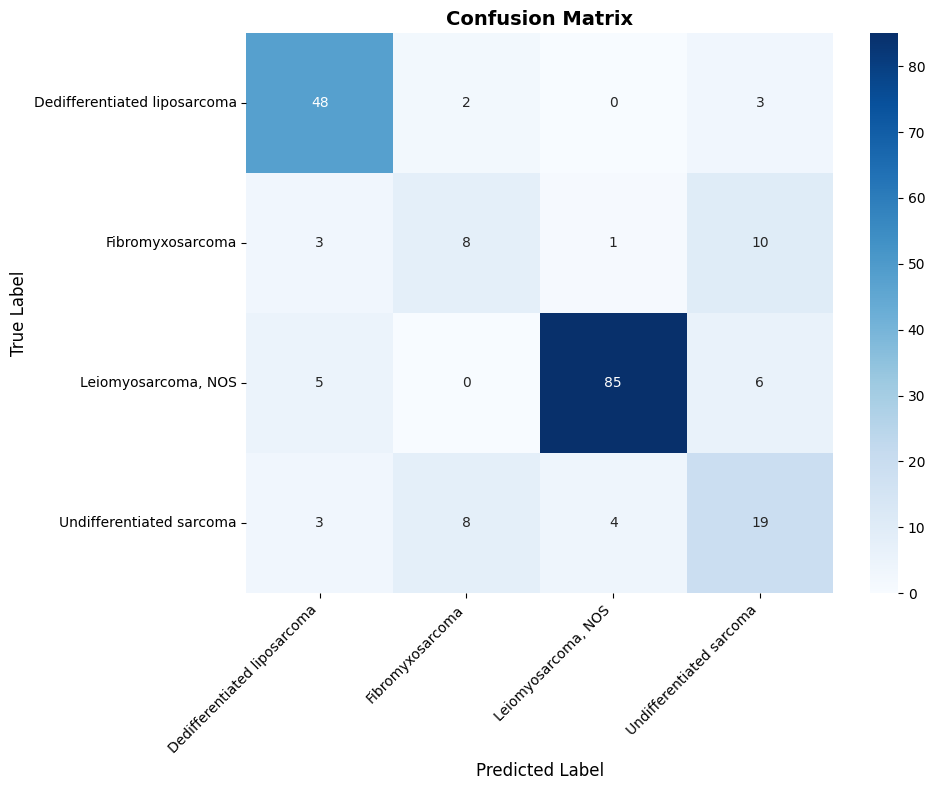

Confusion matrix saved to 'confusion_matrix.png'


In [24]:
cm = confusion_matrix(Y, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to 'confusion_matrix.png'")

In [25]:
n_clusters = len(class_names)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(all_embeddings)

print(f"\n{'='*60}")
print("CLUSTERING ANALYSIS (K-Means)")
print(f"{'='*60}")
print(f"  Number of clusters: {n_clusters}")


CLUSTERING ANALYSIS (K-Means)
  Number of clusters: 4


In [26]:
print(f"\n{'='*60}")
print("CLUSTERING SCORES")
print(f"{'='*60}")

# 1. Silhouette Score (internal: -1 to 1, higher is better)
sil_score = silhouette_score(all_embeddings, Y)
sil_score_kmeans = silhouette_score(all_embeddings, cluster_labels)
print(f"  Silhouette Score (True Labels):    {sil_score:.4f}")
print(f"  Silhouette Score (K-Means):        {sil_score_kmeans:.4f}")

# 2. NMI - Normalized Mutual Information (0 to 1, higher is better)
nmi_score = normalized_mutual_info_score(Y, cluster_labels)
print(f"  NMI (Normalized Mutual Info):      {nmi_score:.4f}")

# 3. ARI - Adjusted Rand Index (-1 to 1, higher is better)
ari_score = adjusted_rand_score(Y, cluster_labels)
print(f"  ARI (Adjusted Rand Index):         {ari_score:.4f}")

# 4. Calinski-Harabasz Index (higher is better, measures cluster separation)
ch_score = calinski_harabasz_score(all_embeddings, Y)
ch_score_kmeans = calinski_harabasz_score(all_embeddings, cluster_labels)
print(f"  Calinski-Harabasz (True Labels):   {ch_score:.4f}")
print(f"  Calinski-Harabasz (K-Means):       {ch_score_kmeans:.4f}")

# 5. Davies-Bouldin Index (lower is better, measures cluster compactness)
db_score = davies_bouldin_score(all_embeddings, Y)
db_score_kmeans = davies_bouldin_score(all_embeddings, cluster_labels)
print(f"  Davies-Bouldin (True Labels):      {db_score:.4f}")
print(f"  Davies-Bouldin (K-Means):          {db_score_kmeans:.4f}")

# Summary table
cluster_summary = pd.DataFrame({
    'Metric': ['Silhouette', 'NMI', 'ARI', 'Calinski-Harabasz', 'Davies-Bouldin'],
    'Score (True Labels)': [sil_score, nmi_score, ari_score, ch_score, db_score],
    'Score (K-Means)': [sil_score_kmeans, nmi_score, ari_score, ch_score_kmeans, db_score_kmeans],
    'Interpretation': ['Higher=Better', 'Higher=Better', 'Higher=Better', 'Higher=Better', 'Lower=Better']
})
print(f"\n{cluster_summary.to_string(index=False)}")


CLUSTERING SCORES
  Silhouette Score (True Labels):    0.0126
  Silhouette Score (K-Means):        0.1451
  NMI (Normalized Mutual Info):      0.0612
  ARI (Adjusted Rand Index):         0.0656
  Calinski-Harabasz (True Labels):   4.7564
  Calinski-Harabasz (K-Means):       19.9064
  Davies-Bouldin (True Labels):      7.7783
  Davies-Bouldin (K-Means):          2.4371

           Metric  Score (True Labels)  Score (K-Means) Interpretation
       Silhouette             0.012569         0.145072  Higher=Better
              NMI             0.061156         0.061156  Higher=Better
              ARI             0.065596         0.065596  Higher=Better
Calinski-Harabasz             4.756385        19.906434  Higher=Better
   Davies-Bouldin             7.778269         2.437149   Lower=Better



Computing t-SNE...


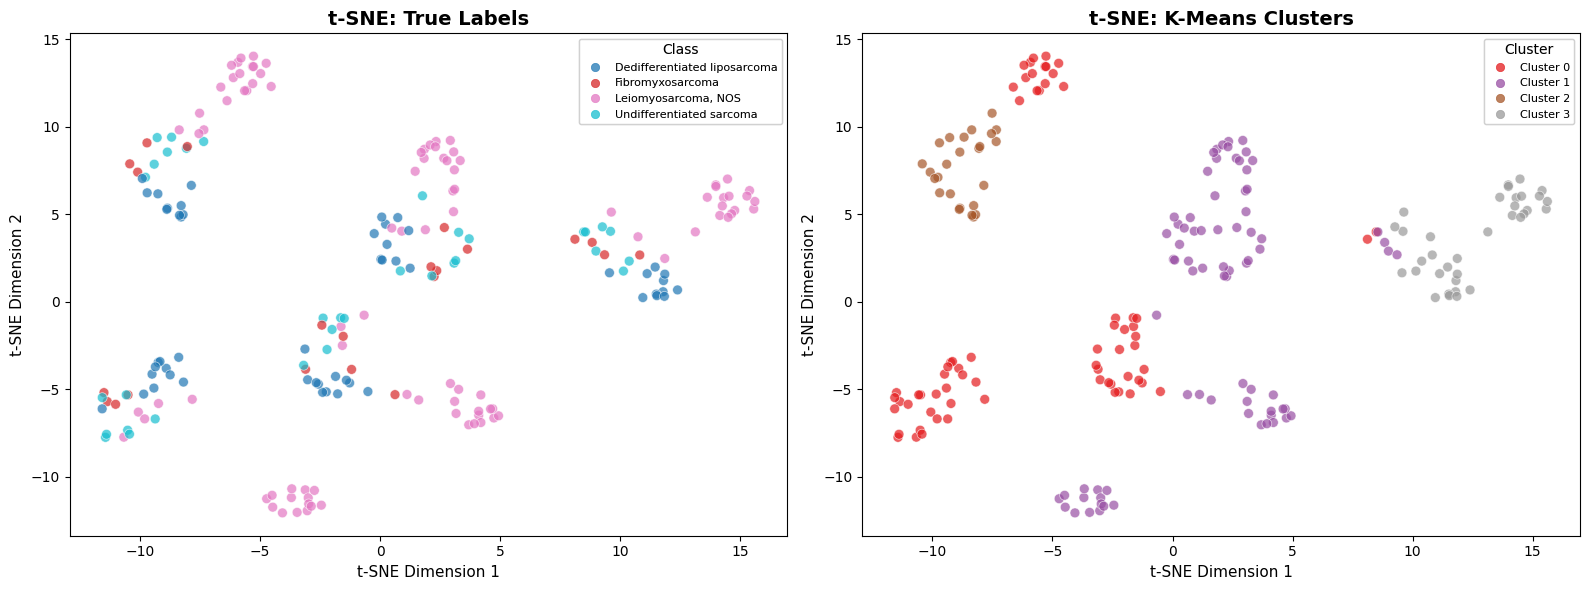

t-SNE visualization saved to 'tsne_visualization.png'


In [27]:
# t-SNE Visualization
print("\nComputing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(all_embeddings)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: True Labels
scatter1 = axes[0].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                           c=Y, cmap='tab10', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
axes[0].set_title('t-SNE: True Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11)
legend1 = axes[0].legend(handles=scatter1.legend_elements()[0], labels=list(class_names), 
                         title="Class", loc='upper right', fontsize=8)
axes[0].add_artist(legend1)

# Plot 2: K-Means Clusters
scatter2 = axes[1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                           c=cluster_labels, cmap='Set1', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
axes[1].set_title('t-SNE: K-Means Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
legend2 = axes[1].legend(handles=scatter2.legend_elements()[0], 
                         labels=[f'Cluster {i}' for i in range(n_clusters)], 
                         title="Cluster", loc='upper right', fontsize=8)
axes[1].add_artist(legend2)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("t-SNE visualization saved to 'tsne_visualization.png'")


Computing UMAP...


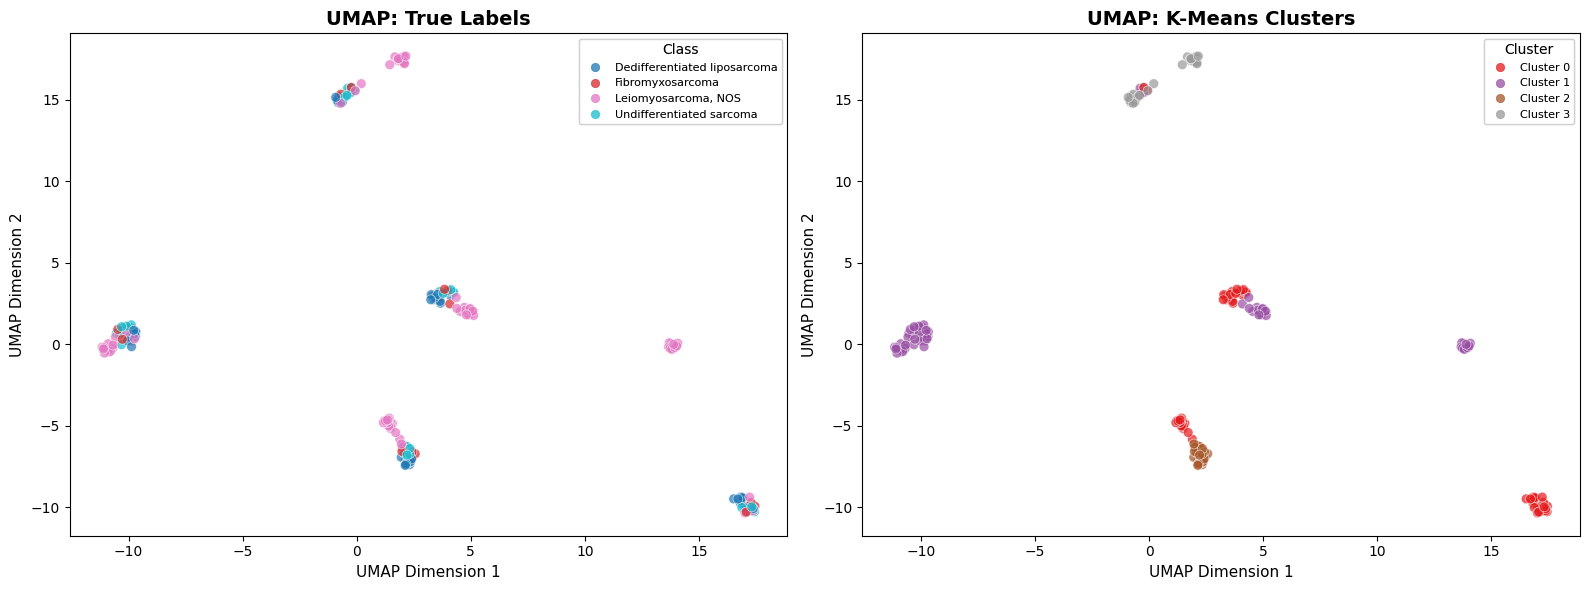

UMAP visualization saved to 'umap_visualization.png'


In [28]:
if HAS_UMAP:
    print("\nComputing UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_umap = reducer.fit_transform(all_embeddings)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: True Labels
    scatter1 = axes[0].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                               c=Y, cmap='tab10', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
    axes[0].set_title('UMAP: True Labels', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('UMAP Dimension 1', fontsize=11)
    axes[0].set_ylabel('UMAP Dimension 2', fontsize=11)
    legend1 = axes[0].legend(handles=scatter1.legend_elements()[0], labels=list(class_names), 
                             title="Class", loc='upper right', fontsize=8)
    axes[0].add_artist(legend1)

    # Plot 2: K-Means Clusters
    scatter2 = axes[1].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                               c=cluster_labels, cmap='Set1', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
    axes[1].set_title('UMAP: K-Means Clusters', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('UMAP Dimension 1', fontsize=11)
    axes[1].set_ylabel('UMAP Dimension 2', fontsize=11)
    legend2 = axes[1].legend(handles=scatter2.legend_elements()[0], 
                             labels=[f'Cluster {i}' for i in range(n_clusters)], 
                             title="Cluster", loc='upper right', fontsize=8)
    axes[1].add_artist(legend2)

    plt.tight_layout()
    plt.savefig('umap_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("UMAP visualization saved to 'umap_visualization.png'")
else:
    print("UMAP not available. Install with: pip install umap-learn")

In [29]:
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")

print("\n### Classification Metrics (5-Fold CV):")
print(f"  - Accuracy:   {mean_metrics['accuracy']:.4f} ± {std_metrics['accuracy']:.4f}")
print(f"  - F1-Macro:   {mean_metrics['f1_macro']:.4f} ± {std_metrics['f1_macro']:.4f}")
print(f"  - F1-Micro:   {mean_metrics['f1_micro']:.4f} ± {std_metrics['f1_micro']:.4f}")
print(f"  - Precision:  {mean_metrics['precision']:.4f} ± {std_metrics['precision']:.4f}")
print(f"  - Recall:     {mean_metrics['recall']:.4f} ± {std_metrics['recall']:.4f}")

if all(x != -1 for x in fold_metrics['c_index']):
    print(f"  - C-Index:    {mean_metrics['c_index']:.4f} ± {std_metrics['c_index']:.4f}")

print("\n### Clustering Metrics:")
print(f"  - Silhouette Score:      {sil_score:.4f}")
print(f"  - NMI:                   {nmi_score:.4f}")
print(f"  - ARI:                   {ari_score:.4f}")
print(f"  - Calinski-Harabasz:     {ch_score:.4f}")
print(f"  - Davies-Bouldin:        {db_score:.4f}")

print("\n>>> EVALUATION COMPLETE!")



FINAL SUMMARY

### Classification Metrics (5-Fold CV):
  - Accuracy:   0.7805 ± 0.0463
  - F1-Macro:   0.6744 ± 0.0773
  - F1-Micro:   0.7805 ± 0.0463
  - Precision:  0.6799 ± 0.0871
  - Recall:     0.6835 ± 0.0725

### Clustering Metrics:
  - Silhouette Score:      0.0126
  - NMI:                   0.0612
  - ARI:                   0.0656
  - Calinski-Harabasz:     4.7564
  - Davies-Bouldin:        7.7783

>>> EVALUATION COMPLETE!
